The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
x0 =  18.52443504333496


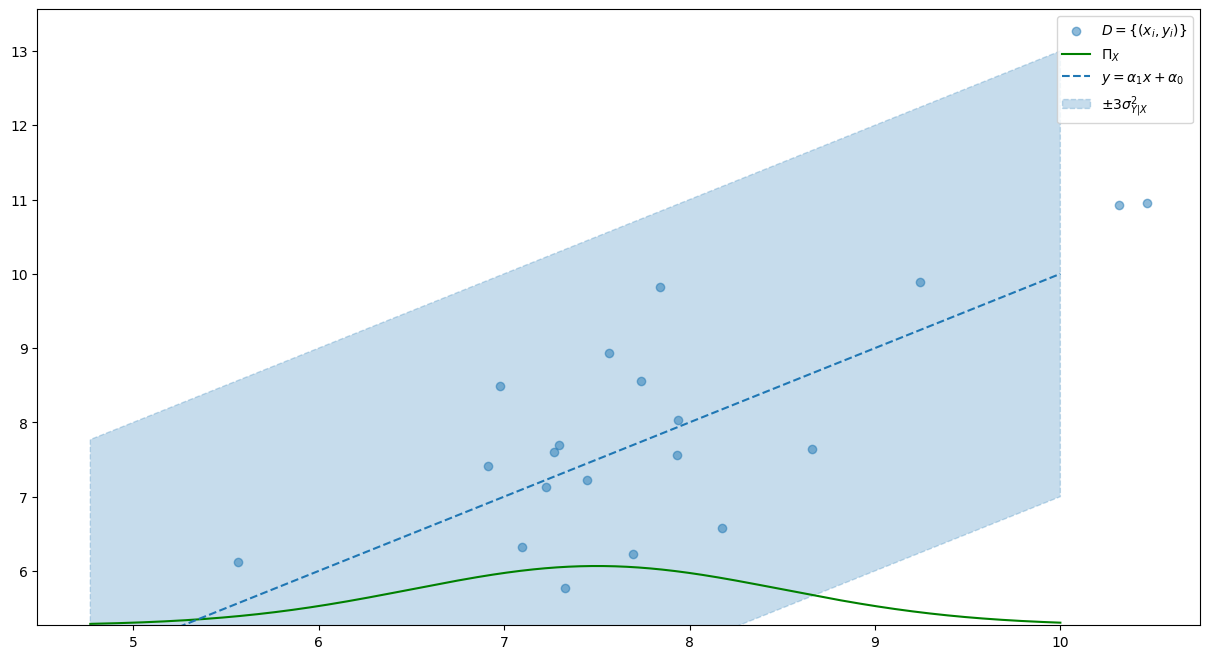

In [27]:
import torch
import matplotlib.pyplot as plt
from regressor import *
from utils import *
%load_ext autoreload
%autoreload 2

scale_sigma2 = torch.tensor(.5)
shape_sigma2 = torch.tensor(.5)
sigma20 = pyro.distributions.InverseGamma(shape_sigma2, scale_sigma2).sample()
sigma20 = torch.tensor(1.)

mu_beta = torch.zeros(2)
Sigma_beta = torch.eye(2)
beta0 =torch.distributions.MultivariateNormal(mu_beta, Sigma_beta).sample()
beta0 = torch.tensor([1.,0.])

mu_X =torch.tensor(7.5)
sigma2_X =torch.tensor(1.)
x0 =  torch.distributions.Normal(mu_X, torch.sqrt(sigma2_X)).sample() + 10

prior_dataset = torch.distributions.Normal(mu_X, sigma2_X)
n_D = 20
DX =prior_dataset.sample([n_D])

sigma2_simulateur = torch.tensor(1)
f = lambda x: beta0[0]*x + beta0[1] 
simulateur= lambda x: f(x) + torch.randn(x.shape[0])*torch.sqrt(sigma20)
DY = simulateur(DX)


print('x0 = ',str(x0.item()))
n_y0= 1
y0 = simulateur(x0.repeat(n_y0))

plt.figure(figsize = (15,8))
y_min = torch.min(torch.cat([DY,y0])) - 0.5
plt.scatter(DX.numpy(), DY.numpy(), alpha =.5, label = r'$D=\{(x_i,y_i)\}$')

tt = torch.linspace(torch.min(DY)-1, 10,500)
plt.plot(tt, y_min + 2*torch.exp(torch.distributions.Normal(mu_X, torch.sqrt(sigma2_X)).log_prob(tt.unsqueeze(-1))), color = 'green', label=r'$\Pi_X$')
plt.plot(tt.numpy(),f(tt).numpy(), linestyle = '--', label = r'$y = \alpha_1x+ \alpha_0$', color ='C0')
plt.fill_between(tt.numpy(),f(tt).numpy() - 3*torch.sqrt(sigma20).numpy(),f(tt).numpy() + 3*torch.sqrt(sigma20).numpy(),linestyle = '--',color = 'C0',alpha = 0.25, label = '$\pm 3\sigma^2_{Y|X}$')
plt.ylim(y_min,)
plt.legend()
plt.show()

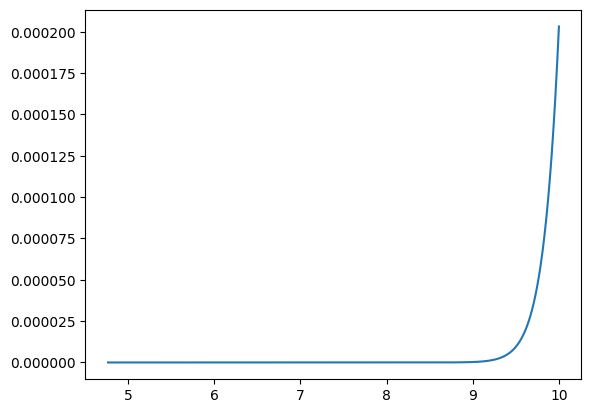

In [28]:
true_posterior_sigma2 = 1/(1/sigma2_X + n_y0*(beta0[0]**2)/sigma20)
true_posterior_mean = true_posterior_sigma2*(mu_X/sigma2_X + torch.square(beta0[0])*torch.sum(y0-beta0[1])/sigma20)
true_posterior = torch.distributions.Normal(true_posterior_mean, torch.sqrt(true_posterior_sigma2))
plt.plot(tt, torch.exp(true_posterior.log_prob(tt)))

In [29]:
list_prior = []
list_xj = []
list_yj = []
n_unlabeled_obs = 10
n_per_obs = 1
for t in torch.linspace(-20,20,n_unlabeled_obs):
    prior = torch.distributions.Normal(t, 1)
    list_prior.append(prior)
    xj = prior.sample()
    list_xj.append(xj)
    yj = simulateur(xj.unsqueeze(0).repeat(n_per_obs))
    list_yj.append(yj.unsqueeze(0))
if n_unlabeled_obs>0:
    Y = torch.cat(list_yj, dim = 0)
else: 
    Y = torch.tensor([])
blr = discriminative_bayesian_affine_regression()
X0_, _,_ = blr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, Y,torch.linspace(-20,20,n_unlabeled_obs), torch.ones(n_unlabeled_obs), number_steps=10000, verbose = True)
X0,_,_ = blr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, number_steps =10000, verbose = True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1322.21it/s]


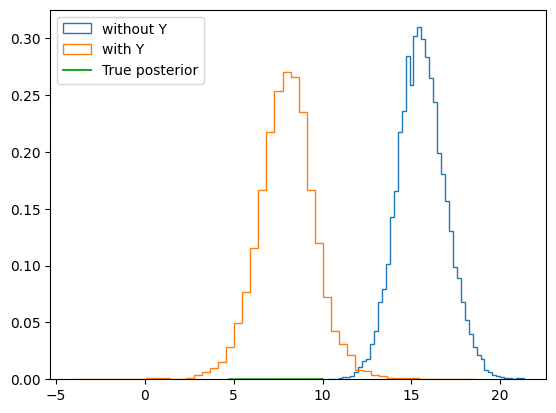

In [30]:
plt.hist(X0, histtype ='step', bins = 50, density = True, label = 'without Y')
plt.hist(X0_, histtype ='step', bins = 50, density = True, label = 'with Y')
plt.plot(tt, torch.exp(true_posterior.log_prob(tt)), label = 'True posterior')
plt.legend()
plt.show()